# **"Absorption correction routines for multiple samples with arbitrary shapes.**
#### The documentation can be found at: https://arxiv.org/abs/2410.08313
#### The absorption correction program includes predefined samples like cuboids, cylinders, half-cylinders, spheres, etc.

# ----------------------------------------------------------

### **Absorption correction of a half cylinder. **
#### Half cylinder sample radius r height l


In [1]:
# Download and Install abscorr program
!git clone https://github.com/macsatncnr/abscorrpython
%cd abscorrpython
import numpy as np
import abscorr as abcr
import time

Cloning into 'abscorrpython'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 87.76 KiB | 5.85 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/abscorrpython


In [2]:
def half_cylinder_sample(r,l):

    """
    Defining a half cylinder sample radius r height l
    4 boundary surfaces,

    IMPORTANT:
        Boundaries are defined as
        F= Ax^2 + By^2 + Cz^2+ Dxy + Eyz + Gzx +Hx +Iy +Jz = fu(x,y,z)
        The sample must be located at (0,0,0). There is not need to be centered
        The sample must be defined as a set of convex boundaries.
        Cylinder radius r, height l

        x^2+y^2=r^2  A=1 B=1 F=r^2      boundary eq 1
        z=l/2   J=1  F=1/2              boundary eq 2
        z=-l/2  J=2  F=-l/2             boundary eq 3
        y=0     I=1  F=0                boundary eq 4

        inside value is a defined volume element inside the volume of interest.
        all the lenght units are in cm

    """
    F=np.zeros((4,10),dtype=float)
    #Circle
    #Circle x^2+y^2=r^2  A=1 B=1 F=r^2
    F[0,0]=1.0;      #A=1.0
    F[0,1]=1.0;      #B=1.0
    F[0,9]=r**2;  	  #F=r^2

    #Plane 1
    #plane z=l/2 ->  J=1, F=l/2
    F[1,8]=1.0;      #J=1.0
    F[1,9]=l/2;     #F=l/2
    #Plane 2
    #plane z=-l/2 ->  J=1, F=-l/2
    F[2,8]=1.0;        #J=1.0
    F[2,9]=-1.0*l/2;  #F=-l/2
    #plane 3 y=0  I=1  F=0
    F[3,7]=1;    # I=1
    F[3,9]=0;   #F=0


    VEI=[0,r/2,0]                 #VEI= define volume element inside
    box_bottom=[-1*r,0,-1*l/2]   #box lower corner
    box_dimensions=[2*r,r,l]      #box dimensions
    box_deltas=[55,55,55]           #box number volumeo elements in each direction
    sample={'F':F,'VEI':VEI,'box_bottom':box_bottom,'box_dimensions':box_dimensions,'box_deltas':box_deltas}
    return sample

In [3]:
def half_cylinder_sample_transm(theta,twotheta,r,l,mu_ei,mu_ef,**kwargs):
    """
    Calculate the transmission for a half cylinder given theta and twotheta
    theta=0 when the flat side of the cylider is perpendicular to the incindent
    beam.  s0=[0,1,0],     flat side plane  y=0

    Parameters
    ----------
    theta : float
        theta value
    twotheta : float
        twotheta value.
    r : float
        sphere radius in cm
    l : float
        sphere length in cm
    mu_ei : float
        inear absorption coefficient for ei in cm^-1
    mu_ef : float
        inear absorption coefficient for ef in cm^-1

    Returns
    -------
    absorption : fluat
        Calculated transmission given a theta and twotheta value for a sample define as a box.

    """

    s0=[0.0,1.0,0.0]    #   Incident beam
    s=[0.0,1.0,0.0]     #   Scattered beam
    half_cyl_smpl=half_cylinder_sample(r,l)
    ss0=abcr.srotxy(s0,-1*theta)
    ss=abcr.srotxy(abcr.srotxy(s,-1*theta),twotheta)
    transm=abcr.integ(ss0, ss, half_cyl_smpl,mu_ei,mu_ef)
    print(theta,twotheta,transm)
    if 'file_out' in kwargs:
       file2write=kwargs["file_out"]
       with open(file2write, 'a') as ff:
           np.savetxt(ff,[[theta,twotheta,transm]],fmt='%1.3f',delimiter='\t')

    if 'return_list' in kwargs:
        return_list=kwargs["return_list"]
        return_list.append([theta,twotheta,transm])
    return transm

In [4]:
def single_position():
    theta=30
    twotheta=120
    r=1.0
    l=0.5
    mu_ei=2.0
    mu_ef=2.0
    print(half_cylinder_sample_transm(theta,twotheta,r,l,mu_ei,mu_ef))

In [5]:
def trans_sample_sequential(angles,**kwargs):
    """
    Parameters
    ----------

    angles:
                angles :    Two columns list [theta, twotheta]
                            List with two columns list of floats
                            [theta, twotheta] values to compute transmission.

                            String
                            if  angles is a "string" then angles is a file name
                            with the angles theta_twotheta.
                            The file  must have two columns list of floats  [theta, twotheta]


    **kwargs :  file_out :  file to save the calculated transmission with 3 columns:
                            [theta, twotheta, transmission]

    Returns
    -------
                A list with with three columns [theta, twotheta, transmission]
    """
    r=1.0
    l=0.5
    mu_ei=2.0
    mu_ef=2.0
    startime=time.time()
    if type(angles)==str:
        file2read=angles
        with open(file2read, 'r') as ff:
            angles=np.loadtxt(ff)

    if 'file_out' in kwargs:
       file2write=kwargs["file_out"]
       ff=open(file2write, 'w')
       ff.close()

    transmi=[half_cylinder_sample_transm(angle[0],angle[1],r,l,mu_ei,mu_ef,**kwargs) for angle in angles]

    print('done.', time.time()-startime)
    return transmi


In [6]:
def trans_test():
    """

    Returns
    -------
    None.

    Calculate the transmission sequencially and save it to test_cylinder90.txt'
    For multiprocessign see file cylinder_90deg_mpt.py


    """
    range_theta=[0,360,20]
    range_twotheta=[0,200,20]
    angles=abcr.generate_Sample_theta_2theta(range_theta, range_twotheta)
    file_out='test_half_cylinder.txt'
    trans_sample_sequential(angles,file_out=file_out)


### Plot the transmission.

In [7]:
def plot_transmission():
    abcr.generate_contour_plot("test_half_cylinder.txt")

### Call trans_test and plot_transmission

0 0 0.19673211518383318
0 20 0.1889716157924552
0 40 0.17352717580605964
0 60 0.15689548587013233
0 80 0.14042950527494716
0 100 0.17597785529050253
0 120 0.23563338553544388
0 140 0.2700199430127538
0 160 0.28860269450813203
0 180 0.2952926669168054
20 0 0.18116175823061845
20 20 0.18911244220085016
20 40 0.1817522187203942
20 60 0.16715580195393645
20 80 0.15162025690677394
20 100 0.13631191456318284
20 120 0.17267334045243088
20 140 0.2317027427263685
20 160 0.2651061900565251
20 180 0.28256961512198575
40 0 0.148571432062814
40 20 0.1661772193148417
40 40 0.17562515942178641
40 60 0.1702721738722196
40 80 0.15870595785797068
40 100 0.14666166841116668
40 120 0.1347416019974386
40 140 0.17284272781707188
40 160 0.22783566859712365
40 180 0.25441766674115346
60 0 0.10909463196881009
60 20 0.13120019557562979
60 40 0.15264974085121408
60 60 0.16576707514557806
60 80 0.16515871998532797
60 100 0.15933789744572507
60 120 0.15251064311914983
60 140 0.14399850464171904
60 160 0.1794385558

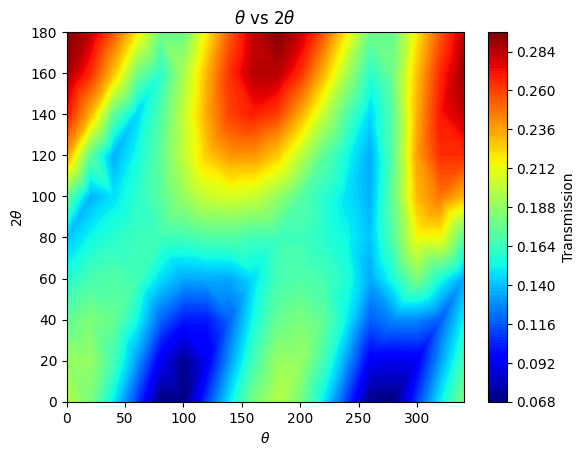

In [8]:
trans_test()
plot_transmission()

Download file.

In [9]:
from google.colab import files
files.download("test_half_cylinder.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>